## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [ ]:
import os
import sys
import glob
import numpy as np
import pickle
import cv2
import skimage.filters
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from moviepy.editor import VideoFileClip
from IPython.display import HTML


############################################################################
# This function is used to calibrate the camera and undistort the img
############################################################################
def camera_calibration(cal_img_path):
    '''
        This function is used to calibrate the camera 
        
        Parameters:
            cal_img_path: Path to calibration images
        
            
        Returns: 
            mtx: Camera matrix
            dist: Distortion coefficients
            
            
    '''
    calibration_file = os.path.join(cal_img_path, 'calibration.pkl')
    # Check for camera calibration pickle file
    if os.path.exists(calibration_file):
        f = open(calibration_file, 'rb')
        [mtx, dist] = pickle.load(f)
        f.close()
        return mtx, dist
    else:
        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        # Setup object points
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        # Read in list of calibration images
        images = glob.glob(cal_img_path + '\calibration*.jpg')

        # Loop through each calibration image 
        for img_file in images:
            # Read in image
            img = cv2.imread(img_file)

            # Convert image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

            # Add object points and image points if corners are found
            if ret == True:
                # Append image points and object points to list
                imgpoints.append(corners)
                objpoints.append(objp)

                # Draw the corners
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

        # Get camera calibration info
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
        f = open(calibration_file, 'wb')
        pickle.dump([mtx, dist], f)
        f.close()

        # Return camera matrix and distortion coefficients
        return mtx, dist



### Test camera calibration function

In [ ]:
cal_img_path = '.\camera_cal'
test_img = './test_images/straight_lines1.jpg'
mtx, dist = camera_calibration(cal_img_path)

# Read in a test image
img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Undistort test image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Show distorted vs undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('dist_udist_test_img.jpg')

### Perspective Transform

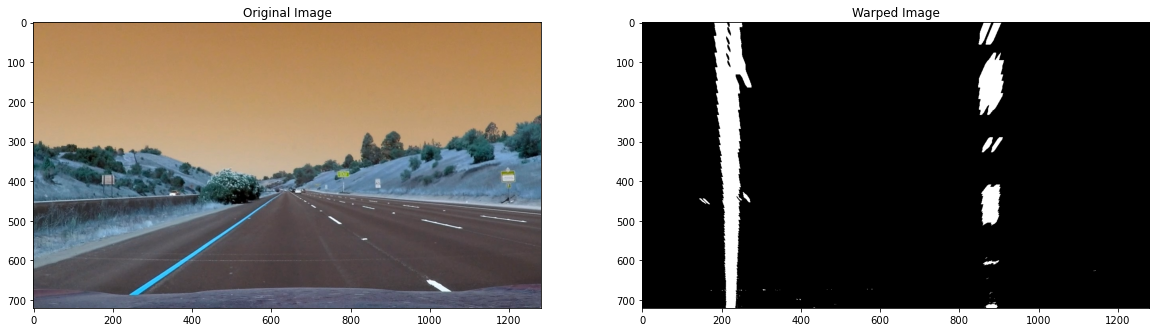

In [32]:
import cv2
img_path = "test_images"
cal_img_path = '.\camera_cal'
test_img = ['./test_images/straight_lines1.jpg']

IMG_SIZE = 1280, 720 # x,y
WARPED_SIZE = 600, 500 # x,y

# Read in list of test images
images = glob.glob(os.path.join(img_path,'*.jpg'))
harder_img = [os.path.join(os.getcwd(), './Harder_Video_Frames/frame222.jpg')]

def get_transform_points():
    #Source point coordinates
    pt1 = [725, 455]
    pt2 = [555, 455]
    pt3 = [1280, 680]
    pt4 = [0, 680]
    src = np.float32([pt1, pt2, pt3, pt4])
    
    # Destination point coordinates
    dpt1 = [1080, 0]
    dpt2 = [0, 0]
    dpt3 = [1082, 720]
    dpt4 = [0, 720]
    dst = np.float32([dpt1, dpt2, dpt3, dpt4])

#     width = img.shape[1]
#     height = img.shape[0]
#     src = np.array([[(width*0.4, height*0.65),
#                         (width*0.6, height*0.65),
#                         (width, height),
#                         (0, height)]], 
#                         dtype=np.float32)
#     dst = np.array([[0,0], 
#                     [img.shape[1], 0], 
#                     [img.shape[1], img.shape[0]],
#                     [0, img.shape[0]]],
#                     dtype = 'float32')


    
#     image = np.copy(img)

#     plt.figure()
#     plt.plot(pt1[0], pt1[1], 'bo')
#     plt.plot(pt2[0], pt2[1], 'bo')
#     plt.plot(pt3[0], pt3[1], 'bo')
#     plt.plot(pt4[0], pt4[1], 'bo')

    
#     plt.plot(dpt1[0], dpt1[1], 'ro')
#     plt.plot(dpt2[0], dpt2[1], 'ro')
#     plt.plot(dpt3[0], dpt3[1], 'ro')
#     plt.plot(dpt4[0], dpt4[1], 'ro')
#     plt.imshow(image)
    
    return src, dst

def calculate_perspective_transforms(src, dst):

    # Comput perspective transform
    m = cv2.getPerspectiveTransform(src, dst)
    
    # Compute inverse perspective tranform
    m_inv = cv2.getPerspectiveTransform(dst, src)
    
    return m, m_inv


def perspective_transform(m, img):
    
    img_size = (img.shape[1], img.shape[0])
    
    # Create warped image
    warped_img = cv2.warpPerspective(img, m, img_size, flags=cv2.INTER_LINEAR)
    
    return warped_img

def inverse_perspective_transform(m_inv, img):
    
    img_size = (img.shape[1], img.shape[0])
    
    unwarp_img = cv2.warpPerspective(img, m_inv, img_size, flags=cv2.INTER_LINEAR)
    
    return unwarp_img
    


# Calibrate the camera
mtx, dist = camera_calibration(cal_img_path)

# Loop through test images
for img_file in test_img:
    
    # Read image as BGR
    img = cv2.imread(img_file)
    
    # Create a copy of the distored image
    dist_img = np.copy(img)
    
    # Undistort test image
    udist_img = cv2.undistort(dist_img, mtx, dist, None, mtx)
    
    # Get transform points
    src, dst = get_transform_points()
    
    combined_binary = image_thresholding(udist_img)
    
    # Calculate transform
    m, m_inv = calculate_perspective_transforms(src, dst)
    
    # Warp image to a "birds eye view"
    warped_img = perspective_transform(m, combined_binary)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    
    ax1.set_title("Original Image")
    ax1.imshow(img)
    ax2.set_title("Warped Image")
    ax2.imshow(warped_img, cmap='gray')
    plt.savefig("Perspective Transform")
    break
    
    

### Caluclate distance per pixel between lane lines


(135, 760, 3)
0.004815789473684211
0.02259259259259259


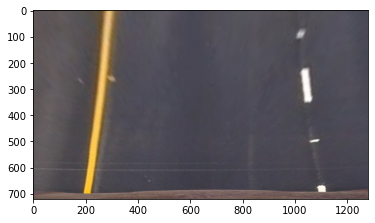

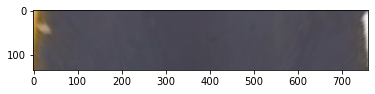

In [4]:
test_image = './test_images/straight_lines1.jpg'

img = cv2.imread(test_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Undistort test image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Get transform points
src, dst = get_transform_points()

# Calculate transform
m, m_inv = calculate_perspective_transforms(src, dst)

# Warp image to a "birds eye view"
warped_img = perspective_transform(m, img)


# create a window for the yellow and white dashed line
measurement_window = warped_img[220:355, 275:1035]

print(measurement_window.shape)

# To calculate meters per pixel for width assume lane is 3.66m the minimum requred width by US Law
meterpp_h = 3.66 / measurement_window.shape[1]

# To calculate meters per pixel for height assume dashed lane is 3.05m the minimum required height by US Law
meterpp_v = 3.05 / measurement_window.shape[0]

plt.figure()
plt.imshow(warped_img)
plt.figure()
plt.imshow(measurement_window)

print(meterpp_h)
print(meterpp_v)

# Save the warp parameters to disk
warp_params = {"m": m,
               "m_inv": m_inv,
               "image_width_height": (1280,720),
               "warped_width_height": (1280,720),
               "mppv": meterpp_v,
               "mpph": meterpp_h}
with open("warp_params.p", "wb") as f:
     pickle.dump(warp_params, f)


### Gradient and Color Thresholding

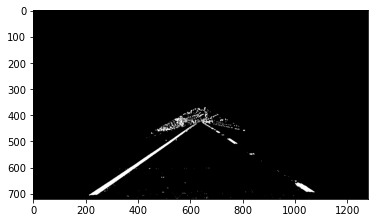

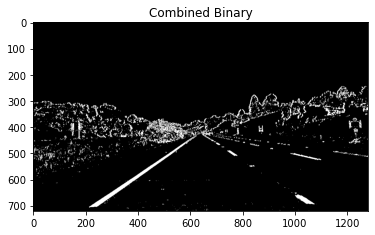

In [30]:
img_path = "test_images"
cal_img_path = '.\camera_cal'

# Read in list of test images
images = glob.glob(os.path.join(img_path,'*.jpg'))

# Calibrate the camera
#mtx, dist = camera_calibration(cal_img_path)
    
def show_images(img, mask, colorspace):
    '''
    This function is used for debugging and testing
    '''
    
    # Seperate image channels
    ch1, ch2, ch3 = cv2.split(img)
    
    # Create plots
    if mask is not None:
        f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 25))
    else:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 25))
        

    ax1.set_title(str(colorspace))
    ax1.imshow(img)

    ax2.set_title(colorspace[0])
    ax2.imshow(ch1)

    ax3.set_title(colorspace[1])
    ax3.imshow(ch2)

    ax4.set_title(colorspace[2])
    ax4.imshow(ch3)

    if mask is not None:
        ax5.set_title('binary')
        ax5.imshow(mask, cmap='gray')
        
def dir_threshold(gray, kernel_size=3, thresh=(0, np.pi/2)):
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    

    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    
    dir_mask = np.zeros_like(direction)
    dir_mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    
    return dir_mask


def gradient_magnitude(gray, sobel_kernel=9, mag_threshold=(40, 125)):
    '''
    This function takes the gradient mangnitude of sobelx and sobely
    operators.
    '''
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_threshold[0]) & (gradmag <= mag_threshold[1])] = 1
    return binary_output

def sobel_thresh(gray, dir='x', min_thresh=0, max_thresh=255):
        
    if dir == 'x':
        # Sobel x
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    else:
        sobel = cv2.Sobel(Gray, cv2.CV_64F, 0, 1)
    
    abs_sobel = np.absolute(sobel) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    binary_img = np.zeros_like(scaled_sobel)
    binary_img[(scaled_sobel >= min_thresh) & (scaled_sobel <= max_thresh)] = 1
    
    return binary_img


        
def hist(img):
    '''
     This function is used to get the histogram for 
     the bottom half of an input image
    '''
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

def erode_and_dilate(binary):
    '''
    Function is not currently used in the pipeline but 
    can be used for removing noise from the image. 
    '''
    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(binary, kernel, iterations=1)

    kernel = np.ones((12, 12), np.uint8)
    dilation = cv2.dilate(erosion, kernel, iterations=2)
    return dilation
        
test_images = ['./test_images/test1.jpg']


def image_thresholding(warped_img):
    '''
    This function applies all of the image thresholding (color and gradient) for the input image.
    '''
    
    # Create a copy of bgr image
    bgr = np.copy(warped_img)
    
    
    
    #############################################
    # Color Thresholding
    #############################################
    # Convert to rgb color space
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    
    #############################
    # Find white and yellow  pixels in an rgb image
    dark = np.array([220, 180, 180], dtype='uint8')
    light = np.array([255, 255, 255], dtype='uint8')
    # Create mask for white in HLS image
    white_mask = cv2.inRange(rgb, dark, light)

    # Find yellow pixels on rgb image
    dark = np.array([225, 0, 0], dtype='uint8')
    light = np.array([255, 255, 204], dtype='uint8')          
    # Create mask for yellow in hls image
    yellow_mask = cv2.inRange(rgb, dark, light)

    # Bitwise and both masks with HLS image
    img_masked = cv2.bitwise_and(rgb, rgb, mask=(white_mask|yellow_mask)).astype(np.uint8)
    
    rgb_binary = cv2.cvtColor(img_masked, cv2.COLOR_RGB2GRAY)
    
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     plt.figure()
#     plt.imshow(rgb_binary, cmap='gray')

 
    ########################################
    # R channel binary threshold
    r, g, b, = cv2.split(rgb)
    
    # Create a color threshold for r channel of rgb
    r_min = np.array(220, dtype='uint8')
    r_max = np.array(255, dtype='uint8')
    r_binary = np.zeros_like(r)
    r_binary[(r >= r_min) & (r <= r_max)] = 1
    #show_images(rgb, r_binary, "RGB" )
    
    #################################################
    # S channel binary threshold
    
    # Convert to hls color space: H 0-180 S,L 0-255 
    hls = cv2.cvtColor(bgr, cv2.COLOR_BGR2HLS)
    h, l, s = cv2.split(hls)
    
    # Create a color threshold for s channel of hls
    s_min = np.array(170, dtype='uint8')
    s_max = np.array(255, dtype='uint8')
    s_binary = np.zeros_like(s)
    s_binary[(s >= s_min) & (s <= s_max)] = 1
    #show_images(hls, s_binary, "HLS" )
    
    
    ###############################################
    # Gradient Thresholding using sobel x
    ###############################################
    
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    sx_binary = sobel_thresh(gray, dir='x', min_thresh=20, max_thresh=180)
#     plt.figure()
#     plt.title("sx_binary")
#     plt.imshow(sx_binary, cmap='gray')
    
    
    # Gradient direction threshold to only look for vertical edges
    sx_dir_binary = dir_threshold(gray, thresh=(np.pi/2, np.pi/3))
#     plt.figure()
#     plt.title("sobel x dir")
#     plt.imshow(sx_dir_binary, cmap='gray')
    
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(sx_binary == 1) | (s_binary == 1) | (r_binary == 1)  | (rgb_binary == 1)]  = 1
    
    
    # Plot
#     f, (ax1) = plt.subplots(1, 1, figsize=(15, 15))
#     ax1.set_title('combined_binary')
#     ax1.imshow(combined_binary, cmap='gray')
    
    return combined_binary


image_files = []
test_path = './project_video_frames/frame'
for i in range(592, 593):
    file_path = test_path + str(i) + '.jpg'
    image_files.append(file_path)   
#image_files = ['./project_video_frames/frame1025.jpg','./project_video_frames/frame1026.jpg', './project_video_frames/frame1027.jpg']
# Loop through test images
for img_file in test_img:
    
    # Read image as BGR
    img = cv2.imread(img_file)
    
    # Create a copy of the distored image
    dist_img = np.copy(img)
    
    # Undistort test image
    udst_img = cv2.undistort(dist_img, mtx, dist, None, mtx)
    
    combined_binary = image_thresholding(udst_img)
    
    # Apply a region of interest mask
    img_h = warped_img.shape[0]
    img_w = warped_img.shape[1]
    roi_mask = np.zeros_like(combined_binary)
    vertices = np.array([[0,img_h - 1], [img_w / 2, int(0.5 * img_h)], [img_w - 1, img_h - 1]], dtype=np.int32)
    cv2.fillPoly(roi_mask, [vertices], 1)
    roi = cv2.bitwise_and(combined_binary, roi_mask)
    plt.figure()
    plt.imshow(roi, cmap='gray')
    
    
    # Get transform points
    src, dst = get_transform_points()
    
    # Calculate transform
    m, m_inv = calculate_perspective_transforms(src, dst)
    
    # Warp image to a "birds eye view"
    warped_img = perspective_transform(m, combined_binary)
   
    #dilated_binary = erode_and_dilate(combined_binary)
    
    histogram = hist(warped_img)
    
    plt.figure()
    plt.title("Combined Binary")
    plt.imshow(combined_binary, cmap='gray')
    plt.imsave('./output_images/binary_thresholded.jpg', combined_binary)
    
#     plt.figure()
#     plt.imshow(warped_img, cmap='gray')
#     plt.figure()
#     plt.plot(histogram)
    
    
    
    
    
    


### Fit lane Lines using sliding window

In [74]:
import pandas as pd 


def histogram(binary_warped):

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftx_base, rightx_base


def blind_search(binary_warped, nwindows=9, debug=True):
    
    # Create an output image to draw on and visualize the result
    if debug:
        
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    leftx_base, rightx_base = histogram(binary_warped)

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    #pd.DataFrame(binary_warped).to_csv("binary_warped.csv")
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        if debug:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
       
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = None
    right_fit = None
    
    if leftx.size != 0: 
        left_fit = np.polyfit(lefty, leftx, 2)
        
    if rightx.size != 0:
        right_fit = np.polyfit(righty, rightx, 2)

        
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if debug:
        # Visualization ##
        #Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        f, (ax1) = plt.subplots(1, 1, figsize=(10,10))
        #ax1.plot(left_fitx, ploty, color='yellow')
        #ax1.plot(right_fitx, ploty, color='yellow')
        ax1.imshow(out_img)
        plt.savefig('./output_images/sliding_window.jpg', out_img)
    
    return left_fit, right_fit, ploty, left_fitx, right_fitx


def smart_search(binary_warped, left_fit, right_fit, debug=True):
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    
#     left_x = np.polyval(left_fit, nonzeroy)
#     right_x = np.polyval(right_fit, nonzerox)
    
#     left_lane_inds = ((nonzerox > left_x- margin) & (nonzerox < left_x + margin))
#     right_lane_inds = ((nonzerox > right_x - margin) & (nonzerox < right_x + margin))
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Did not detect one or both lane lines, fallback to blind search
    if leftx.size == 0 or rightx.size == 0:
        print("revert to blind search")
        return blind_search(binary_warped)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    if debug:
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.figure()
#         plt.plot(left_fitx, ploty, color='blue')
#         plt.plot(right_fitx, ploty, color='red')
        plt.imshow(result)
        plt.imsave('./output_images/smart_search.jpg', result)
        ## End visualization steps ##
    

    return left_fit, right_fit, ploty, left_fitx, right_fitx
    




### Lane Curvature 

In [75]:
def get_lane_curvature(y, left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(y)
    
    left_fit_cr = np.polyfit(y * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(y * ym_per_pix, right_fitx * xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

# Get Intercepts 
def get_intercepts(fit, y):

    x = fit[0] * (y * y) + fit[1] * y + fit[2]
    return x


    
    

### Lane Finding Pipeline


In [83]:
from collections import deque
lost_frame_count = 0
xm_per_pix = 3.5/720 # meters per pixel in x dimension

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        # Initialize all other member variables 
        self.reset()
        
    def reset(self):
        # Lost frame count
        self.lost_frame_count = 0
        
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
    
        #average x values of the fitted line over the last n iterations
        self.bestx = None    
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit_coeff = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit_coeff = []  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = []
        self.avg_line_pos = None
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        # y values for detected line pixels
        self.ally = None
        
        def pop_left(self):
            pass
        

        
   
        
def draw_poly(image, warped, ploty, left_fitx, right_fitx, m_inv, debug=True):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    if debug:
        plt.figure()
        plt.imshow(result)
        
    return result


left_lane = Line()
right_lane = Line()


def process_image(img):
    global lost_frame_count
    
    if lost_frame_count > 3:
        left_lane.reset()
        right_lane.reset()
    
    # Read image as BGR
    #img = cv2.imread(img)

    # Create a copy of the distored image
    dist_img = np.copy(img)

    # Undistort test image
    undist_img = cv2.undistort(dist_img, mtx, dist, None, mtx)
    
    # Image thresholding
    binary_thresh = image_thresholding(undist_img)

    # Get transform points
    src, dst = get_transform_points()

    # Calculate transform
    m, m_inv = calculate_perspective_transforms(src, dst)

    # Warp image to a "birds eye view"
    binary_warped = perspective_transform(m, binary_thresh)


    # If lane was found in the last frame do a smart search
    if left_lane.detected and right_lane.detected:
        left_fit, right_fit, ploty, left_fitx, right_fitx = smart_search(binary_warped, left_lane.best_fit_coeff, right_lane.best_fit_coeff, debug=False)

    # Else perform sliding window blind search
    else:
        left_fit, right_fit, ploty, left_fitx, right_fitx = blind_search(binary_warped, debug=False)
    
    # Lines were detected
    if left_fitx is not None and right_fitx is not None:
        
        # Lane Width Sanity Check
        left_xpos = get_intercepts(left_fit, img.shape[0])
        right_xpos = get_intercepts(right_fit, img.shape[0])
        lane_width = (right_xpos - left_xpos) * xm_per_pix
    
        if lane_width < 2 or lane_width > 5:
            sanity_check = False
        else:
            sanity_check = True
            
        if sanity_check:
            left_lane.detected = True
            right_lane.detected = True
            
            # If list is larger then 3 remove the oldest fit
            if len(right_lane.current_fit_coeff) > 3:
                left_lane.current_fit_coeff = left_lane.current_fit_coeff[len(left_lane.current_fit_coeff)-5:]
                right_lane.current_fit_coeff = right_lane.current_fit_coeff[len(right_lane.current_fit_coeff)-5:]
                
                left_lane.recent_xfitted = left_lane.recent_xfitted[len(left_lane.recent_xfitted)-5:]
                right_lane.recent_xfitted = right_lane.recent_xfitted[len(right_lane.recent_xfitted)-5:]
            
            # Append current polynomial coefficients
            left_lane.current_fit_coeff.append(left_fit)
            right_lane.current_fit_coeff.append(right_fit)
            
            left_lane.line_base_pos.append(left_xpos)
            right_lane.line_base_pos.append(right_xpos)
            
            # Append x fit
            left_lane.recent_xfitted.append(left_fitx)
            right_lane.recent_xfitted.append(right_fitx)
        
            left_lane.bestx = np.mean(left_lane.recent_xfitted, axis=0)
            right_lane.bestx = np.mean(right_lane.recent_xfitted, axis=0)
            
            left_lane.best_fit_coeff = np.mean(left_lane.current_fit_coeff, axis=0)
            right_lane.best_fit_coeff = np.mean(right_lane.current_fit_coeff, axis=0)
            
            left_lane.avg_line_pos = np.mean(left_lane.line_base_pos)
            right_lane.avg_line_pos = np.mean(right_lane.line_base_pos)
            
                
                
        else:
            if left_lane.bestx is None or right_lane.bestx is None:
                # Lost frame and there is no previous history
                lost_frame_count += 1
                return img
    # No lines detected
    else:
        # if lane lines have no history then frame will be lost
        if left_lane.bestx is None or right_lane.bestx is None:
            lost_frame_count += 1
            return img
        
    lost_frame_count = 0
    
    
    # Calculate Curvature
    left_curverad , right_curverad = get_lane_curvature(ploty, left_lane.bestx, right_lane.bestx)
    avg_curverad = (left_curverad + right_curverad)/2
    
    
    # Compute vehicle offset from center of the road
    lane_center = (right_lane.avg_line_pos + left_lane.avg_line_pos)/2
    
    # Compute offset from center 
    center_offset_pixels = img.shape[1]/2 - lane_center
    offset = xm_per_pix  * center_offset_pixels

    
    result = draw_poly(img, binary_warped, ploty, left_lane.bestx, right_lane.bestx, m_inv, debug=False)
    
    text = "Left curve:  {:10.2f} meters".format(left_curverad)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, text, (10, 60), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    text = "Right curve: {:10.2f} meters".format(right_curverad)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, text, (10, 100), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    text = "Offset:    {:10.2f} meters".format(offset)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, text, (10, 140), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    text = "Lane Width: {:10.2f} meters".format(lane_width)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, text, (10, 180), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

    return result
# image_files = []
# test_path = './project_video_frames/frame'
# for i in range(592, 612):
#     file_path = test_path + str(i) + '.jpg'
#     image_files.append(file_path)
test_image = ['./test_images/straight_lines1.jpg', './test_images/straight_lines2.jpg']
image_files = ['./project_video_frames/frame552.jpg','./project_video_frames/frame553.jpg', './project_video_frames/frame554.jpg']

#for image_file in test_image:
#     #print(image_file)
    #plt.figure()
    #process_image(image_file)
    #plt.imshow(result)
    #plt.imsave('./output_images/final_result.jpg', result)
#     plt.figure()
#     plt.imshow(process_image(image_file))
    
    
    



    
    
  

In [84]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import numpy as np
# from lane_tracker import LaneTracker
# img_size = [720, 1280]
# warp_filepath = './warp_params.p'
# with open(warp_filepath, "rb") as f:
#     warp_params = pickle.load(f)

# M = warp_params['m']
# Minv = warp_params['m_inv']
# image_width_height = warp_params['image_width_height']
# warped_width_height = warp_params['warped_width_height']
# mppv = warp_params['mppv']
# mpph = warp_params['mpph']
# #print(warp_params)

# cal_filepath = './calibration.pkl'
# with open(cal_filepath, "rb") as f:
#     cal_params = pickle.load(f)

# mtx, dist = cal_params


#lt = LaneTracker(img_size, mtx, dist)
# Set up lines for left and right

white_output = 'project_video_test_3.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|▎                                                                                                                                                                                                      | 2/1260 [00:00<01:09, 18.06it/s, now=None]

Moviepy - Building video project_video_test_3.mp4.
Moviepy - Writing video project_video_test_3.mp4



Moviepy - Done !
Moviepy - video ready project_video_test_3.mp4
Wall time: 2min 16s
